# Fitzhugh-Nagumo simplified action-potential model

This example shows how the [Fitzhugh-Nagumo simplified action potential (AP) model](http://www.scholarpedia.org/article/FitzHugh-Nagumo_model) can be used.

The model is based on a simplification and state-reduction of the original squid axon model by Hodgkind and Huxley.
It has two state variables, a voltage-like variable and a recovery variable.


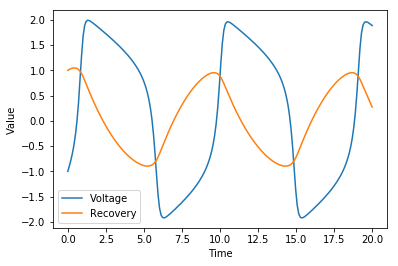

In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create a model
model = pints.toy.FitzhughNagumoModel()

# Run a simulation
parameters = [0.1, 0.5, 3]
times = np.linspace(0, 20, 200)
values = model.simulate(parameters, times)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, values)
plt.legend(['Voltage', 'Recovery'])
plt.show()

With these parameters, the model creates wide AP waveforms that are more reminiscent of muscle cells than neurons.

We now set up a simple optimisation problem with the model.

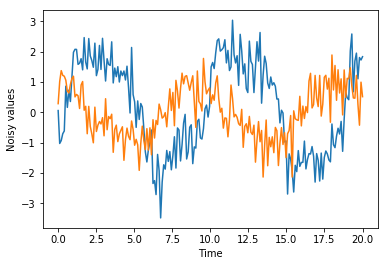

In [2]:
# First add some noise
sigma = 0.5
noisy = values + np.random.normal(0, sigma, values.shape)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Noisy values')
plt.plot(times, noisy)
plt.show()

Next, we set up a problem. Because this model has multiple outputs (2), we use a [MultiOutputProblem](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#multi-output-problem).

In [3]:
problem = pints.MultiOutputProblem(model, times, noisy)
score = pints.SumOfSquaresError(problem)

Finally, we choose a wide set of boundaries and run!

In [4]:
# Select boundaries
boundaries = pints.RectangularBoundaries([0., 0., 0.], [10., 10., 10.])

# Select a starting point
x0 = [1, 1, 1]

# Perform an optimization
found_parameters, found_value = pints.optimise(score, x0, boundaries=boundaries)

print('Score at true solution:')
print(score(parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(parameters[k]))

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7      943.7289   0:00.2
1     14     908.4755   0:00.2
2     21     908.4755   0:00.3
3     28     190.9373   0:00.3
20    147    152.225    0:01.7
40    287    100.9938   0:03.9
60    427    99.87823   0:06.2
80    567    99.87628   0:08.5
100   707    99.87628   0:10.8
120   847    99.87628   0:13.0
140   987    99.87628   0:15.2
160   1127   99.87628   0:17.4
180   1267   99.87628   0:19.6
200   1407   99.87628   0:21.9
220   1547   99.87628   0:24.1
240   1687   99.87628   0:26.3
260   1827   99.87628   0:28.6
280   1967   99.87628   0:30.9
300   2107   99.87628   0:33.1
320   2247   99.87628   0:35.4
340   2387   99.87628   0:37.6
360   2527   99.87628   0:39.8
380   2667   99.87628   0:42.1
400   2807   99.87628   0:44.4
420   2947   99.87628   0:46.6
440   3087   99.87628   0:48.9
451   3157   99.87628   0:50

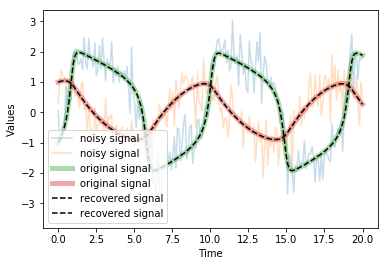

In [5]:
# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, noisy, '-', alpha=0.25, label='noisy signal')
plt.plot(times, values, alpha=0.4, lw=5, label='original signal')
plt.plot(times, problem.evaluate(found_parameters), 'k--', label='recovered signal')
plt.legend()
plt.show()

This shows the parameters are not retrieved entirely correctly, but the traces still strongly overlap.

## Sampling with Monomial-gamma HMC

The Fitzhugh-Nagumo model has sensitivities calculated by the forward sensitivities approach, so we can use samplers that use gradients (although they will be slower per iteration; although perhaps not by ESS per second!), like Monomial-gamma HMC.

In [6]:
import time

problem = pints.MultiOutputProblem(model, times, noisy)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0, 0],
    [10, 10, 10, 20, 20]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters1 = np.array(parameters + [sigma, sigma])
xs = [
    real_parameters1 * 1.1,
    real_parameters1 * 0.9,
    real_parameters1 * 1.15,
    real_parameters1 * 1.5,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 4, xs, method=pints.MonomialGammaHamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(10)

# Run in parallel
mcmc.set_parallel(True)

# time start
start = time.time()

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# end time
end = time.time()
time = end - start

Running...
Using Monomial-Gamma Hamiltonian Monte Carlo


pints/_mcmc/_monomial_gamma_hamiltonian.py:273: RuntimeWarning: overflow encountered in exp
  1.0 + np.exp(c * self._g(p, a, m)))


Generating 4 chains.
Running in parallel with 4 worker processess.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:14.7
1     84     0.333     0.333     0.333     0.333      0:16.9
2     164    0.5       0.5       0.5       0.5        0:19.2
3     244    0.6       0.6       0.6       0.6        0:21.5
10    724    0.818     0.818     0.818     0.818      0:35.3
Halting: Maximum number of iterations (10) reached.
Done!


Print results.

In [7]:
results = pints.MCMCSummary(chains=chains, time=time, parameter_names=["a", "b", "c", "sigma_V", "sigma_R"])
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
a        0.12    0.02    0.09    0.10   0.11   0.12   0.15     27.63   3.05   0.09
b        0.57    0.10    0.45    0.52   0.54   0.61   0.75     10.19   3.28   0.09
c        3.34    0.53    2.75    2.98   3.11   3.56   4.45     3.85    3.66   0.10
sigma_V  0.60    0.12    0.45    0.53   0.57   0.63   0.84     8.41    3.09   0.09
sigma_R  0.58    0.12    0.44    0.52   0.56   0.62   0.77     25.30   3.09   0.09


Plot the few posterior predictive simulations versus data.

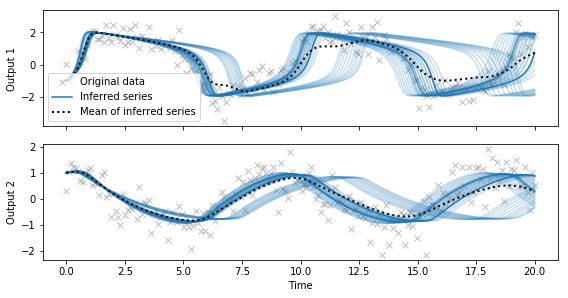

In [9]:
import pints.plot
pints.plot.series(np.vstack(chains), problem)
plt.show()